In [1]:
import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)
import kinodyn_um.urdfparser as u2c
import kinodyn_um.utils.plucker as pluck
import kinodyn_um.utils.quaternion as quatT
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull

In [2]:
alpha = u2c.URDFparser()
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
path_to_urdf = os.path.join(
    project_root,
    'usage',
    'urdf',
    'alpha_5_robot.urdf'
)
alpha.from_file(path_to_urdf)

root = "base_link"
tip = "alpha_standard_jaws_base_link"

joint_min = np.array([1.00, 0.01, 0.01, 0.01])
joint_max = np.array([5.50, 3.40, 3.40, 5.70])
base_T0 = [3.142, 0.000, 0.000, 0.190, 0.000, -0.120] #transformation of uv body frame to manipulator base

n_joints = alpha.get_n_joints(root, tip)
i_X_0fs = alpha.forward_kinematics(root, tip, floating_base = True)

q = ca.SX.sym("q", n_joints)
baseT_xyz = ca.SX.sym('T_xyz', 3) # manipulator-vehicle mount link xyz origin 
baseT_rpy = ca.SX.sym('T_rpy', 3) # manipulator-vehicle mount link rpy origin
base_T = ca.vertcat(baseT_rpy, baseT_xyz) # transform from origin to 1st child
x = ca.SX.sym('x')
y = ca.SX.sym('y')
z = ca.SX.sym('z')
tr_n = ca.vertcat(x, y, z) # x, y ,z of uv wrt to ned origin
thet = ca.SX.sym('thet')
phi = ca.SX.sym('phi')
psi = ca.SX.sym('psi')
eul = ca.vertcat(phi, thet, psi)  # NED euler angular velocity
p_n = ca.vertcat(tr_n, eul) # ned total states
n = ca.vertcat(p_n, q) #NED position

i_X_0s = i_X_0fs(q, tr_n, eul, baseT_xyz, baseT_rpy)

In [3]:
H0 , R0, p0 = pluck.spatial_to_homogeneous(i_X_0s[0])
T0 = ca.vertcat(p0, quatT.rotation_matrix_to_quaternion(R0, order='wxyz'))
T0_euler = ca.vertcat(p0, pluck.rotation_matrix_to_euler(R0, order='xyz'))
dIFF_KinJ0 = ca.jacobian(T0_euler, ca.vertcat(n))
dIFF2_KinJ0 = ca.jacobian(dIFF_KinJ0, ca.vertcat(n))
# dot_J0 = (dIFF2_KinJ0@arm_ss.dn).reshape((6, 10))

H1 , R1, p1 = pluck.spatial_to_homogeneous(i_X_0s[1])
T1 = ca.vertcat(p1, quatT.rotation_matrix_to_quaternion(R1, order='wxyz'))
T1_euler = ca.vertcat(p1, pluck.rotation_matrix_to_euler(R1, order='xyz'))
dIFF_KinJ1 = ca.jacobian(T1_euler, ca.vertcat(n))
dIFF2_KinJ1 = ca.jacobian(dIFF_KinJ1, ca.vertcat(n))
# dot_J1 = (dIFF2_KinJ1@arm_ss.dn).reshape((6, 10))

H2 , R2, p2 = pluck.spatial_to_homogeneous(i_X_0s[2])
T2 = ca.vertcat(p2, quatT.rotation_matrix_to_quaternion(R2, order='wxyz'))
T2_euler = ca.vertcat(p2, pluck.rotation_matrix_to_euler(R2, order='xyz'))
dIFF_KinJ2 = ca.jacobian(T2_euler, ca.vertcat(n))
dIFF2_KinJ2 = ca.jacobian(dIFF_KinJ2, ca.vertcat(n))
# dot_J2 = (dIFF2_KinJ2@arm_ss.dn).reshape((6, 10))

H3 , R3, p3 = pluck.spatial_to_homogeneous(i_X_0s[3])
T3 = ca.vertcat(p3, quatT.rotation_matrix_to_quaternion(R3, order='wxyz'))
T3_euler = ca.vertcat(p3, pluck.rotation_matrix_to_euler(R3, order='xyz'))
dIFF_KinJ3 = ca.jacobian(T3_euler, ca.vertcat(n))
dIFF2_KinJ3 = ca.jacobian(dIFF_KinJ3, ca.vertcat(n))
# dot_J3 = (dIFF2_KinJ3@arm_ss.dn).reshape((6, 10))

H4 , R4, p4 = pluck.spatial_to_homogeneous(i_X_0s[4])
T4 = ca.vertcat(p4, quatT.rotation_matrix_to_quaternion(R4, order='wxyz'))
T4_euler = ca.vertcat(p4, pluck.rotation_matrix_to_euler(R4, order='xyz'))
dIFF_KinJ4 = ca.jacobian(T4_euler, ca.vertcat(n))
dIFF2_KinJ4 = ca.jacobian(dIFF_KinJ4, ca.vertcat(n))
# dot_J4 = (dIFF2_KinJ4@arm_ss.dn).reshape((6, 10))

fk_eval = ca.Function("fkeval", [n, base_T], [T0, T1, T2, T3, T4])
fk_eval.save("fk_eval.casadi")

# c , cpp or matlab code generation for forward dynamics
fk_eval.generate("fk_eval_.c")
os.system(f"gcc -fPIC -shared fk_eval_.c -o libFK.so")

0

In [4]:
# forward kinematics wrt to NED origin quaternion
T_i = fk_eval([0.2,1,0.5, 0,0,0 , ca.pi, ca.pi, ca.pi, ca.pi],base_T0)
T_i

(DM([0.39, 1.00001, 0.366, 1.24714e-20, -6.12323e-17, 1, 0.000203673]),
 DM([0.41, 1.00002, 0.333, 1, 0.000203673, -6.12448e-17, 6.12199e-17]),
 DM([0.37, 1.00008, 0.1877, -0.000203673, 1, -1.32679e-06, -2.70233e-10]),
 DM([0.39, 1.00009, 0.1547, -0.000176386, 0.866025, 0.500001, 0.000101837]),
 DM([0.39, 1.00013, 0.05495, -0.000176386, 0.866025, 0.500001, 0.000101837]))

In [5]:

min_pos_fb, max_pos_fb, positions_fb = alpha.approximate_workspace(root, tip,list(zip(joint_min, joint_max)), base_T0, floating_base=True, num_samples=15000)
min_pos_fx, max_pos_fx, positions_fx = alpha.approximate_workspace(root, tip,list(zip(joint_min, joint_max)), base_T0, floating_base=False, num_samples=15000)
np.save("workspace.npy", positions_fb)
workspace_points = np.load("workspace.npy")

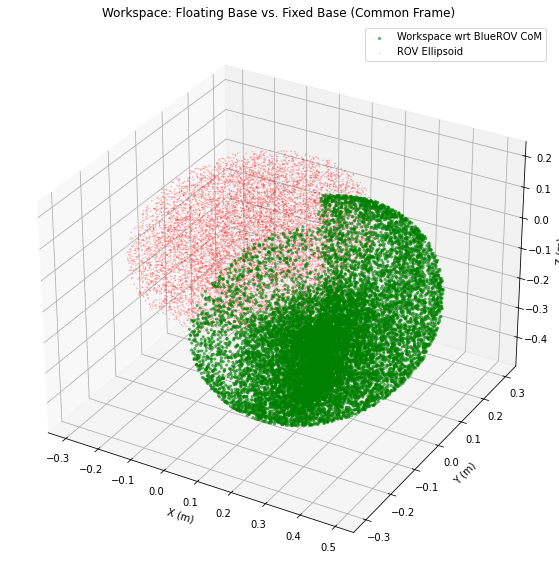

In [6]:
def generate_rov_ellipsoid(a=0.5, b=0.3, c=0.2, num_points=10000):
    points = []
    while len(points) < num_points:
        pt = np.random.uniform(-1, 1, 3)
        if (pt[0]/a)**2 + (pt[1]/b)**2 + (pt[2]/c)**2 <= 1:
            points.append(pt)
    return points

rov_ellipsoid_cl_pts = generate_rov_ellipsoid(a=0.3, b=0.3, c=0.2, num_points=10000) #vehicle cloudpoints

def transform_positions(positions, base_T0):
    """
    positions: (N x 3) array of points (the fixed-base workspace).
    base_T0:   [r, p, y, x, y, z] – we only use the last 3 for translation.
    
    Returns: (N x 3) array, with [x, y, z] offset applied.
    """
    tx, ty, tz = base_T0[3], base_T0[4], base_T0[5]
    return positions + np.array([tx, ty, tz])

def plot_floating_vs_fixed(
    # Floating-base data (wrt BlueROV CoM)
    positions_fb, min_pos_fb, max_pos_fb,
    # Fixed-base data (wrt Reach Alpha base link)
    positions_fx, min_pos_fx, max_pos_fx,
    # base_T0: [r, p, y, x, y, z], used for translation offset
    base_T0,
    # Optional: additional points to plot (e.g., ROV ellipsoid points)
    extra_pts=None
):
    """
    Plots both floating-base and fixed-base workspaces in the same frame,
    with distinct colors for better visual separation. Also optionally plots
    an extra set of points (e.g., ROV ellipsoid) if provided.
    """
    # 1) Shift fixed-base points so their origin aligns with the floating-base reference
    positions_fx_offset = transform_positions(positions_fx, base_T0)

    # 2) Plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(projection='3d')

    # Floating-base workspace: wrt BlueROV CoM
    ax.scatter(
        positions_fb[:, 0], positions_fb[:, 1], positions_fb[:, 2],
        c='green', marker='o', s=5, alpha=0.5,
        label='Workspace wrt BlueROV CoM'
    )

    # # Fixed-base workspace: wrt Reach Alpha base link (shifted)
    # ax.scatter(
    #     positions_fx_offset[:, 0], positions_fx_offset[:, 1], positions_fx_offset[:, 2],
    #     c='blue', marker='^', s=5, alpha=0.5,
    #     label='Workspace wrt Reach Alpha base link'
    # )

    # Plot extra points if provided (e.g., ROV ellipsoid)
    if extra_pts is not None:
        extra_pts = np.array(extra_pts)
        ax.scatter(
            extra_pts[:, 0], extra_pts[:, 1], extra_pts[:, 2],
            c='red', marker='.', s=1, alpha=0.3,
            label='ROV Ellipsoid'
        )

    ax.set_title("Workspace: Floating Base vs. Fixed Base (Common Frame)")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.legend()
    plt.show()
    
plot_floating_vs_fixed(
    positions_fb, min_pos_fb, max_pos_fb,
    positions_fx, min_pos_fx, max_pos_fx,
    base_T0,
    extra_pts=rov_ellipsoid_cl_pts
)
# # wrt bluerov center of mass
# list(zip(min_pos_fb, max_pos_fb))

# # wrt reach alpha base link
# list(zip(min_pos_fx, max_pos_fx))

In [7]:
# Precompute convex hull from your workspace points (positions_fb: (N x 3) array)
workspace_hull = ConvexHull(workspace_points)
vehicle_body_hull = ConvexHull(rov_ellipsoid_cl_pts)

def is_endeffector_point_workspace_valid(point):
    """
    Returns True if 'point' is in the workspace hull but *not* in the vehicle hull.
    Equivalently, we want:  point ∈ (Workspace \ Vehicle) = Workspace ∩ (Vehicle)^c
    """
    inside_workspace = np.all(
        np.dot(workspace_hull.equations[:, :-1], point) + workspace_hull.equations[:, -1] <= 0
    )
    inside_vehicle = np.all(
        np.dot(vehicle_body_hull.equations[:, :-1], point) + vehicle_body_hull.equations[:, -1] <= 0
    )
    # accept the point if it is inside the workspace and *not* inside the vehicle hull.
    return inside_workspace and not inside_vehicle

In [8]:
task_point = np.array([0.31396762,  0.00519786, -0.21436635])  # Example target position

if is_endeffector_point_workspace_valid(task_point):
    print("Task is within the workspace.")
else:
    print("Task is out-of-workspace.")

Task is within the workspace.
